In [129]:
import cv2
import numpy as np
import math
import pandas as pd
import skimage
from matplotlib import pyplot as plt
from scipy import ndimage

image = cv2.imread("./input_ex3.jpg", cv2.IMREAD_COLOR)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

enhancedImage = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

#Using Wikipedia Description for Normalization
arrayImage = (enhancedImage.astype('double') - np.min(enhancedImage.astype('double'))) / (np.max(enhancedImage.astype('double')) - np.min(enhancedImage.astype('double')))

In [130]:
"""
using from the previous assignment
==================================
https://stackoverflow.com/questions/17190649/how-to-obtain-a-gaussian-filter-in-python/45764688#45764688
"""
def gogFilter(sigma, xSize, ySize):
    
    xTemp = np.arange(-xSize/2+0.5, xSize/2)
    yTemp = np.arange(-ySize/2+0.5, ySize/2)
    
    XGrid, YGrid = np.meshgrid(xTemp, yTemp, sparse=True)
    gog = np.exp(-((XGrid**2 + YGrid**2) / (2*(sigma**2))))
    
    return gog/gog.sum()
"""
==================================
"""

'\n==================================\n'

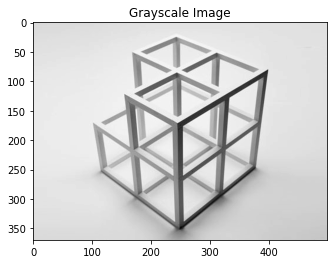

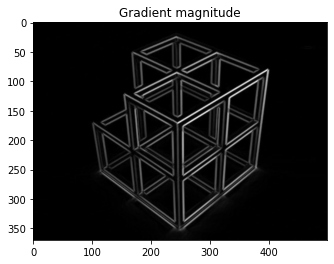

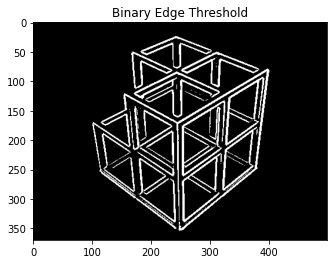

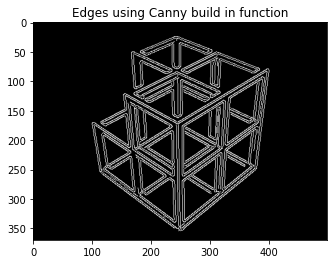

In [131]:
"""
using from the previous assignment
"""
derArray = np.array([2, 1, 0, -1, -2])
gauss = gogFilter(0.5, 1, 3)
filterX = derArray * gauss
# print(filterX)
#Transpose the fx Value using .T
filterY = filterX.T
# print(filterY)

imageX = ndimage.convolve(arrayImage, filterX)
imageY = ndimage.convolve(arrayImage, filterY)

gradMagnitude = np.sqrt(imageX**2 + imageY**2)
angle = (np.arctan2(imageY, imageX)) * (180 / np.pi)


"""============================================================"""
#https://stackoverflow.com/questions/10571874/opencv-imwrite-saving-complete-black-jpeg
arrayImageNormed = 255 * (arrayImage - arrayImage.min()) / (arrayImage.max() - arrayImage.min())
arrayImageNormed = np.array(arrayImageNormed, np.int32)

arrayImageXNormed = 255 * (imageX - imageX.min()) / (imageX.max() - imageX.min())
arrayImageXNormed = np.array(arrayImageXNormed, np.int32)

arrayImageYNormed = 255 * (imageY - imageY.min()) / (imageY.max() - imageY.min())
arrayImageYNormed = np.array(arrayImageYNormed, np.int32)

arrayMagnitudeNormed = 255 * (gradMagnitude - gradMagnitude.min()) / (gradMagnitude.max() - gradMagnitude.min())
arrayMagnitudeNormed = np.array(arrayMagnitudeNormed, np.int32)

"""============================================================"""
# Thresholding the arrayMagnitudeNormed with > 0.5
arrayMagnitudeNormedThreshed = np.zeros(np.shape(arrayMagnitudeNormed));
width, height = arrayMagnitudeNormed.shape
for i in range(1,width-1):
    for j in range(1,height-1):
        if gradMagnitude[i,j] > 0.6:
            arrayMagnitudeNormedThreshed[i,j] = 1;
"""============================================================"""

arrayAngleNormed = 255 * (angle - angle.min()) / (angle.max() - angle.min())
arrayAngleNormed = np.array(arrayAngleNormed, np.int32)

"""
Canny Edge Detection --> we use this to compare the result from our function
https://docs.opencv.org/4.x/da/d22/tutorial_py_canny.html
https://stackoverflow.com/questions/39764885/error-215-src-type-cv-8uc1-in-function-equalizehist-when-trying-to-equ
"""
arrayMagnitudeNormed8 = np.uint8(arrayMagnitudeNormed)
edges = cv2.Canny(arrayMagnitudeNormed8, 100, 200) 
"""============================================================"""

plt.imshow(arrayImageNormed, cmap="gray")
plt.title("Grayscale Image")
plt.show()

plt.imshow(arrayMagnitudeNormed, cmap="gray")
plt.title("Gradient magnitude")
plt.show()

plt.imshow(arrayMagnitudeNormedThreshed, cmap="gray")
plt.title("Binary Edge Threshold")
plt.show()

plt.imshow(edges, cmap="gray")
plt.title("Edges using Canny build in function")
plt.show()

In [132]:
def houghLine(imageData):
    # Rho and Theta ranges
    width, height = imageData.shape
    thetas = np.deg2rad(np.arange(-90.0, 90.0))
    # calc for the max length of the diagonal
    maxDistance = np.ceil(np.sqrt(width * width + height * height))   
    # calc the rhos
    rhos = np.linspace(-int(maxDistance), int(maxDistance), int(maxDistance) * 2)

    cosThetas = np.cos(thetas)
    sinThetas = np.sin(thetas)
    numThetas = len(thetas)

    # Hough accumulator array of theta vs rho
    accumulator = np.zeros((2 * int(maxDistance), numThetas), dtype=np.uint64)
    # (row, col) indexes to edges
    yIndex, xIndex = np.nonzero(imageData)  

    # Vote in the hough accumulator
    for i in range(len(xIndex)):
        x = xIndex[i]
        y = yIndex[i]

        for tIndex in range(numThetas):
            # Calculate rho. diag_len is added for a positive index
            rho = round(x * cosThetas[tIndex] + y * sinThetas[tIndex]) + maxDistance
            accumulator[int(rho), int(tIndex)] += 1

    """
    we return these 3 so we can just use it again for the hough_line_peaks using skiamge
    """
    return accumulator, thetas, rhos

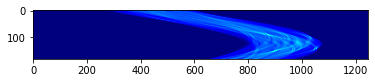

In [133]:
accumulator, thetas, rhos = houghLine(arrayMagnitudeNormedThreshed)

plt.imshow(accumulator.T, cmap='jet')
plt.show()

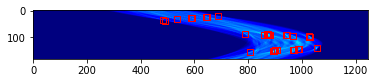

In [134]:
"""
https://stackoverflow.com/questions/56283580/explanation-about-hough-line-peaks-after-using-hough-line
""" 
bestH, bestTheta, bestD = skimage.transform.hough_line_peaks(accumulator, thetas, rhos)

tlist1 = []
tlist2 = []

for i in range(0,accumulator.shape[0], 1):
    for j in range(0,accumulator.shape[1], 1):
        for data in bestH:
            if accumulator[i,j] == data:
                tlist1.append(i)
                tlist2.append(j)
                
plt.imshow(accumulator.T, cmap='jet')
plt.scatter(tlist1,tlist2, marker="s", facecolors='none', color="red")
plt.show()

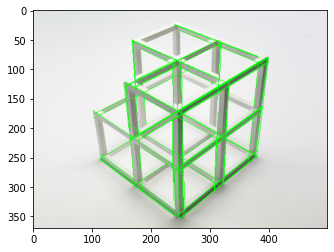

In [135]:
"""
https://opencv24-python-tutorials.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_houghlines/py_houghlines.html
https://stackoverflow.com/questions/39764885/error-215-src-type-cv-8uc1-in-function-equalizehist-when-trying-to-equ
https://stackoverflow.com/questions/35609719/opencv-houghlinesp-parameters
"""
arrayMagnitudeNormedThreshed8 = np.uint8(arrayMagnitudeNormedThreshed)
linesP = cv2.HoughLinesP(arrayMagnitudeNormedThreshed8, 1, np.pi/180, 100, None, 50, 10)
    
if linesP is not None:
    for i in range(0, len(linesP)):
        l = linesP[i][0]
        cv2.line(image, (l[0], l[1]), (l[2], l[3]), (0,255,0), 1)
 
plt.imshow(image, cmap='gray')
plt.show()